In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Install Necessary Packages

In [ ]:
!pip install ffmpeg

In [ ]:
!pip install ffmpeg-python

#Shot Boundary Detection

##Exmple by PySceneDetection

In [ ]:
!pip install scenedetect[opencv]

     |████████████████████████████████| 112kB 7.3MB/s 


In [ ]:
from scenedetect import VideoManager
from scenedetect import SceneManager
from scenedetect.detectors import ContentDetector

def find_scenes(video_path, threshold=30.0):
    video_manager = VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(
        ContentDetector(threshold=threshold))
    video_manager.set_downscale_factor()
    video_manager.start()
    scene_manager.detect_scenes(frame_source=video_manager)
    return scene_manager.get_scene_list()

In [ ]:
trailer_path = '../pre_process/TransNetv2/MovieTrailer/FVrOVlS5TMU.mp4'
scene_list = find_scenes(trailer_path)
scene_list

100%|██████████| 2732/2732 [00:27<00:00, 101.00frames/s]


[(FrameTimecode(frame=0, fps=23.976024),
  FrameTimecode(frame=87, fps=23.976024)),
 (FrameTimecode(frame=87, fps=23.976024),
  FrameTimecode(frame=133, fps=23.976024)),
 (FrameTimecode(frame=133, fps=23.976024),
  FrameTimecode(frame=174, fps=23.976024)),
 (FrameTimecode(frame=174, fps=23.976024),
  FrameTimecode(frame=222, fps=23.976024)),
 (FrameTimecode(frame=222, fps=23.976024),
  FrameTimecode(frame=266, fps=23.976024)),
 (FrameTimecode(frame=266, fps=23.976024),
  FrameTimecode(frame=329, fps=23.976024)),
 (FrameTimecode(frame=329, fps=23.976024),
  FrameTimecode(frame=354, fps=23.976024)),
 (FrameTimecode(frame=354, fps=23.976024),
  FrameTimecode(frame=374, fps=23.976024)),
 (FrameTimecode(frame=374, fps=23.976024),
  FrameTimecode(frame=424, fps=23.976024)),
 (FrameTimecode(frame=424, fps=23.976024),
  FrameTimecode(frame=496, fps=23.976024)),
 (FrameTimecode(frame=496, fps=23.976024),
  FrameTimecode(frame=551, fps=23.976024)),
 (FrameTimecode(frame=551, fps=23.976024),
  Fr

##Example by Transnetv2
---





In [ ]:
from google.colab import drive
import os
os.chdir('../pre_process/TransNetv2')
!ls

build	 dist	    LICENSE	  README.md  training
configs  inference  MovieTrailer  setup.py   transnetv2.egg-info


In [ ]:
!python inference/transnetv2.py '../pre_process/TransNetv2/MovieTrailer' --visualize

2021-06-01 19:06:33.451513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[TransNetV2] Using weights from inference/transnetv2-weights/.
2021-06-01 19:06:35.165323: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-01 19:06:35.191835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-06-01 19:06:35.192409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-06-01 19:06:35.192451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-06-01

#Keyframe Extraction

In [ ]:
import ffmpeg
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas
import os

In [ ]:
def read_single_frame(input_path,frame_num):
  probe = ffmpeg.probe(input_path)
  video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
  width = int(video_stream['width'])
  height = int(video_stream['height'])
  out, err = (
    ffmpeg
    .input(input_path)
    .filter('select', 'gte(n,{})'.format(frame_num))
    .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
    )
  frame = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
    )
  print(frame.shape)
  plt.imshow(frame[0,:,:,:])

def extract_single_frame(trailer_path,output_dir,key_fn):
    out_path = os.path.join(output_dir,'{n}.jpg'.format(n=key_fn))
    stream = ffmpeg.input(trailer_path).filter('select', 'gte(n,{})'.format(key_fn)).output(out_path,vframes=1,format="image2",vcodec="mjpeg").overwrite_output().run()

def keyframe_extraction(trailer_path,output_dir,scene_list):
  file_name = os.path.basename(trailer_path)
  id = file_name.replace('.mp4','')
  scene = len(scene_list)
  output_dir = os.path.join(output_dir,id)
  os.mkdir(output_dir)

  for i in range(scene):
    #start_frame = scene_list[i][0].get_frames() #for frametimecode
    start_frame = np.int(scene_list[i][0])
    print(start_frame)
    start_path = os.path.join(output_dir,'shot_'+'%04d'%i+'_0.jpg')
    start_stream = ffmpeg.input(trailer_path).filter('select', 'gte(n,{})'.format(start_frame)).output(start_path,vframes=1,format="image2",vcodec="mjpeg").overwrite_output().run()
    
    end_frame = np.int(scene_list[i][1])
    end_path = os.path.join(output_dir,'shot_'+'%04d'%i+'_2.jpg')
    end_stream = ffmpeg.input(trailer_path).filter('select', 'gte(n,{})'.format(end_frame)).output(end_path,vframes=1,format="image2",vcodec="mjpeg").overwrite_output().run()
    
    middle_frame = np.int((start_frame+end_frame)/2)
    middle_path = os.path.join(output_dir,'shot_'+'%04d'%i+'_1.jpg')
    middle_stream = ffmpeg.input(trailer_path).filter('select', 'gte(n,{})'.format(middle_frame)).output(middle_path,vframes=1,format="image2",vcodec="mjpeg").overwrite_output().run()
    
    print(start_path)
    print(middle_path)
    print(end_path)

(1, 1080, 1920, 3)


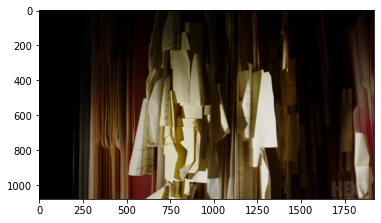

In [ ]:
trailer_path = '../pre_process/TransNetv2/MovieTrailer/FVrOVlS5TMU.mp4'
output_dir = '../pre_process/TransNetv2/Keyframe'
read_single_frame(trailer_path,87)
extract_single_frame(trailer_path,output_dir,87)

In [ ]:
scene_list_path = '../pre_process/TransNetv2/ShotBoundaries/Shots/FVrOVlS5TMU.mp4.shot.txt'
scene_list = np.loadtxt(scene_list_path)
keyframe_extraction(trailer_path,output_dir,scene_list)

0
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0000_0.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0000_1.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0000_2.jpg
34
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0001_0.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0001_1.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0001_2.jpg
87
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0002_0.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pre-Processing/TransNetv2/Keyframe/FVrOVlS5TMU/shot_0002_1.jpg
/content/drive/MyDrive/MasterThesisProject/Code/Video_Pr